This lab on Model Validation using Validation and Cross-Validation is a Python adaptation of p. 248-251 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Adapted by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Model selection using the Validation Set Approach

In Lab 8, we saw that it is possible to choose among a set of models of different
sizes using $C_p$, BIC, and adjusted $R^2$. We will now consider how to do this
using the validation set and cross-validation approaches.

As in Lab 8, we'll be working with the ${\tt Hitters}$ dataset from ${\tt ISLR}$. Since we're trying to predict ${\tt Salary}$ and we know from last time that some are missing, let's first drop all the rows with missing values and do a little cleanup:

In [11]:
df = pd.read_csv('data/Hitters.csv')

# Drop any rows the contain missing values, along with the player names
df = df.dropna().drop('Player', axis=1)

# Get dummy variables
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

# Extract independent variable
y = pd.DataFrame(df.Salary)

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

len(y)

263

In order for the validation set approach to yield accurate estimates of the test
error, we must use *only the training observations* to perform all aspects of
model-fitting — including variable selection. Therefore, the determination of
which model of a given size is best must be made using *only the training
observations*. This point is subtle but important. If the full data set is used
to perform the best subset selection step, the validation set errors and
cross-validation errors that we obtain will not be accurate estimates of the
test error.

In order to use the validation set approach, we begin by splitting the
observations into a training set and a test set. We do this by creating
a random vector, train, of elements equal to TRUE if the corresponding
observation is in the training set, and FALSE otherwise. The vector test has
a TRUE if the observation is in the test set, and a FALSE otherwise. Note the
${\tt np.invert()}$ in the command to create test causes TRUEs to be switched to FALSEs and
vice versa. We also set a random seed so that the user will obtain the same
training set/test set split.

In [4]:
np.random.seed(seed=12)
train = np.random.choice([True, False], size = len(y), replace = True)
test = np.invert(train)

We'll define our helper function to outputs the best set of variables for each model size like we did in Lab 8. Not that we'll need to modify this to take in both test and training sets, because we want the returned error to be the **test** error:

In [5]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

And another function to perform forward selection:

In [6]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

Now, we'll call our ${\tt forward()}$ to the training set in order to perform forward selection for all nodel sizes:

In [7]:
models_train = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_train.loc[i] = forward(predictors, X[train], y[train]["Salary"], X[test], y[test]["Salary"])
    predictors = models_train.loc[i]["model"].model.exog_names

Now let's plot the errors, and find the model that minimizes it:

9

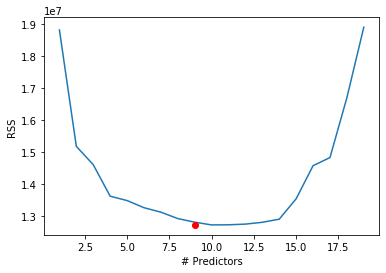

In [9]:
plt.plot(models_train["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train["RSS"].argmin(), models_train["RSS"].min(), "or")
models_train["RSS"].argmin()

Viola! We find that the best model (according to the validation set approach) is the one that contains 10 predictors.

Now that we know what we're looking for, let's perform forward selection on the full dataset and select the best 10-predictor model. It is important that we make use of the *full
data set* in order to obtain more accurate coefficient estimates. Note that
we perform best subset selection on the full data set and select the best 10-predictor
model, rather than simply using the predictors that we obtained
from the training set, because the best 10-predictor model on the full data
set may differ from the corresponding model on the training set.

In [ ]:
models_full = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,20):    
    models_full.loc[i] = forward(predictors, X, y["Salary"], X, y["Salary"])
    predictors = models_full.loc[i]["model"].model.exog_names

In fact, we see that the best ten-variable model on the full data set has a
**different set of predictors** than the best ten-variable model on the training
set:

In [ ]:
print(models_train.loc[10, "model"].model.exog_names)
print(models_full.loc[10, "model"].model.exog_names)

# Model selection using Cross-Validation

Now let's try to choose among the models of different sizes using cross-validation.
This approach is somewhat involved, as we must perform forward selection within each of the $k$ training sets. Despite this, we see that
with its clever subsetting syntax, ${\tt python}$ makes this job quite easy. First, we
create a vector that assigns each observation to one of $k = 10$ folds, and
we create a DataFrame in which we will store the results:

In [ ]:
k=10        # number of folds
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,20))
cv_errors = cv_errors.fillna(0)
cv_errors

Now let's write a for loop that performs cross-validation. In the $j^{th}$ fold, the
elements of folds that equal $j$ are in the test set, and the remainder are in
the training set. We make our predictions for each model size, compute the test errors on the appropriate subset,
and store them in the appropriate slot in the matrix ${\tt cv.errors}$.

In [ ]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
    
# Outer loop iterates over all folds
for j in range(1,k+1):

    # Reset predictors
    predictors = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = forward(predictors, X[folds != (j-1)], y[folds != (j-1)]["Salary"], X[folds == (j-1)], y[folds == (j-1)]["Salary"])
        
        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.loc[i]["RSS"]

        # Extract the predictors
        predictors = models_cv.loc[i]["model"].model.exog_names
        

In [ ]:
cv_errors

This has filled up the ${\tt cv\_errors}$ DataFrame such that the $(i,j)^{th}$ element corresponds
to the test MSE for the $i^{th}$ cross-validation fold for the best $j$-variable
model.  We can then use the ${\tt apply()}$ function to take the ${\tt mean}$ over the columns of this
matrix. This will give us a vector for which the $j^{th}$ element is the cross-validation
error for the $j$-variable model.

In [ ]:
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin(), cv_mean.min(), "or")

We see that cross-validation selects a 9-predictor model. Now let's go back to our results on the full data set in order to obtain the 9-predictor model.

In [ ]:
print(models_full.loc[9, "model"].summary())

For comparison, let's also take a look at the statistics from last lab:

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_full["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_full.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_full.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_full.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Notice how some of the indicators are similar the cross-validated model, and others are very different?

# Your turn!

Now it's time to test out these approaches (best / forward / backward selection) and evaluation methods (adjusted training error, validation set, cross validation) on other datasets. You may want to work with a team on this portion of the lab.

You may use any of the datasets included in ${\tt ISLR}$, or choose one from the UCI machine learning repository (http://archive.ics.uci.edu/ml/datasets.html). Download a dataset, and try to determine the optimal set of parameters to use to model it!

In [ ]:
# Your code here

To get credit for this lab, please post your answers to the following questions:
 - What dataset did you choose?
 - Which selection techniques did you try?
 - Which evaluation techniques did you try?
 - What did you determine was the best set of parameters to model this data?
 - How well did this model perform?
 
to Piazza: https://piazza.com/class/igwiv4w3ctb6rg?cid=35